In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [ ]:
# Загрузка предварительно обученной модели InceptionV3 без верхних слоев
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Добавление своих слоев поверх предварительно обученной модели
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')  # 7 классов для видов птиц
])

# Заморозка весов предварительно обученной модели
base_model.trainable = False

# Компиляция модели
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Создание генератора данных для обучения
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.5, zoom_range=0.5, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_datasets/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

87910968/87910968 [==============================] - 0s 0us/step
Found 1331 images belonging to 7 classes.


In [ ]:
history=model.fit(train_generator, epochs=6)

Epoch 1/6
42/42 [==============================] - 330s 8s/step - loss: 0.6781 - accuracy: 0.7671 - precision: 0.8591 - recall: 0.7055
Epoch 2/6
42/42 [==============================] - 162s 4s/step - loss: 0.3602 - accuracy: 0.8881 - precision: 0.9102 - recall: 0.8527
Epoch 3/6
42/42 [==============================] - 162s 4s/step - loss: 0.3500 - accuracy: 0.8738 - precision: 0.8986 - recall: 0.8588
Epoch 4/6
42/42 [==============================] - 166s 4s/step - loss: 0.2743 - accuracy: 0.9053 - precision: 0.9181 - recall: 0.8933
Epoch 5/6
42/42 [==============================] - 165s 4s/step - loss: 0.2722 - accuracy: 0.8956 - precision: 0.9158 - recall: 0.8820
Epoch 6/6
42/42 [==============================] - 164s 4s/step - loss: 0.2571 - accuracy: 0.9068 - precision: 0.9268 - recall: 0.8941


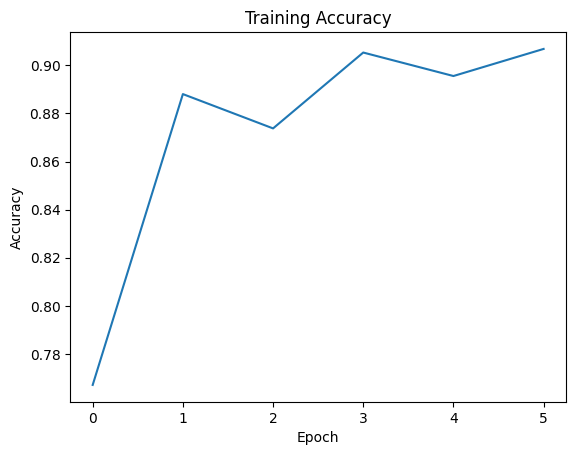

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_datasets/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

evaluation_results = model.evaluate(test_generator)


# Вывод метрик
print("Test Accuracy:", evaluation_results[1])
print("Test Precision:", evaluation_results[2])


# Предсказания для построения матрицы ошибок и отчета классификации
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Матрица ошибок
conf_matrix = confusion_matrix(y_true, y_pred.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Отчет классификации
class_names = list(test_generator.class_indices.keys())
class_report = classification_report(y_true, y_pred.argmax(axis=1), target_names=class_names)
print("Classification Report:")
print(class_report)


Found 280 images belonging to 7 classes.
9/9 [==============================] - 32s 3s/step - loss: 0.2856 - accuracy: 0.9071 - precision: 0.9091 - recall: 0.8929
Test Accuracy: 0.9071428775787354
Test Precision: 0.9090909361839294
9/9 [==============================] - 32s 3s/step
Confusion Matrix:
[[ 4  3 11  3  3  8  8]
 [ 6  3  8  7  7  5  4]
 [ 5  4  4  3 10  7  7]
 [ 4  3  9  6  6  7  5]
 [ 2  4  9  4  6  7  8]
 [10  6  7  4  6  5  2]
 [ 7  3 10  3  4  6  7]]
Classification Report:
              precision    recall  f1-score   support

        гусь       0.11      0.10      0.10        40
      индюки       0.12      0.07      0.09        40
      курица       0.07      0.10      0.08        40
       петух       0.20      0.15      0.17        40
      страус       0.14      0.15      0.15        40
        утка       0.11      0.12      0.12        40
    цыпленок       0.17      0.17      0.17        40

    accuracy                           0.12       280
   macro avg       

In [ ]:
model.save('bird_recognition.keras')

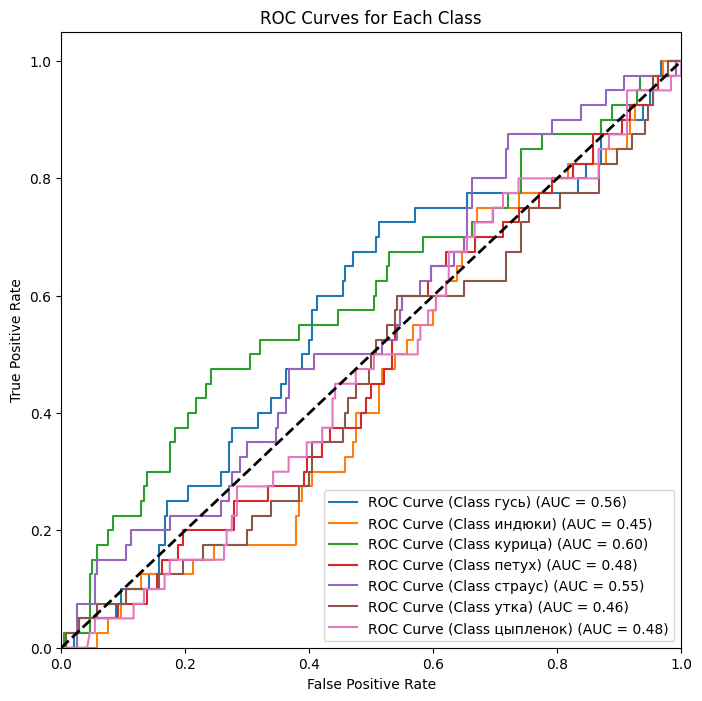

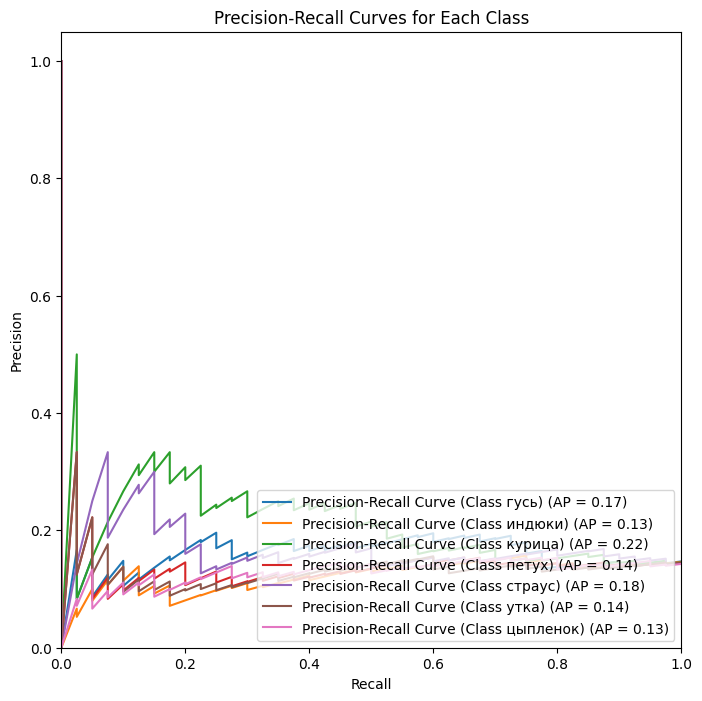

              precision    recall  f1-score   support

        гусь       0.12      0.12      0.12        40
      индюки       0.11      0.12      0.12        40
      курица       0.30      0.23      0.26        40
       петух       0.10      0.10      0.10        40
      страус       0.20      0.20      0.20        40
        утка       0.10      0.10      0.10        40
    цыпленок       0.10      0.10      0.10        40

    accuracy                           0.14       280
   macro avg       0.15      0.14      0.14       280
weighted avg       0.15      0.14      0.14       280



In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Визуализация ROC-кривых
fpr = dict()
tpr = dict()
roc_auc = dict()

# Получение ROC-кривых для каждого класса
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Рисование ROC-кривых
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC Curve (Class {class_names[i]}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

# Визуализация Precision-Recall кривых
precision = dict()
recall = dict()
average_precision = dict()

# Получение Precision-Recall кривых для каждого класса
for i in range(len(class_names)):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred[:, i])

# Рисование Precision-Recall кривых
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(recall[i], precision[i], label=f'Precision-Recall Curve (Class {class_names[i]}) (AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend(loc="lower right")
plt.show()